In [1]:
import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pmlb
from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
import pandas as pd
import data
import numpy.linalg as npl
from scipy.optimize import minimize
import pmlb
%matplotlib inline
%load_ext autoreload
%autoreload 2

save_dir = 'results'
os.makedirs(save_dir, exist_ok=True)

In [2]:
dset = 'mnist'
X, _ = pmlb.fetch_data(dset, return_X_y=True)

# vary p/n
**looks at how MDL-COMP varies as d/n varies.**

In [16]:
def add_results(X_train, X_test, noise_std=0.1, beta_norm=1):
    np.random.seed(13)
    n = X_train.shape[0]
    d = X_train.shape[1]    
    beta = np.ones(d) # flat    
#     beta = np.random.randn(d) 
    beta = np.array([2**(-i) for i in range(d)]) # decay2
    
    beta = beta / np.linalg.norm(beta) * beta_norm 
    y_train = X_train @ beta + noise_std * np.random.randn(n)
    y_test = X_test @ beta + noise_std * np.random.randn(X_test.shape[0])

    u, a, vh = np.linalg.svd(X_train.T @ X_train, full_matrices=True)
    w = vh @ beta
    c = (1 / (2 * X_train.shape[0]))
    logsum = 0
    for i in range(min(n, d)):
        logsum += np.log(1 + a[i] * w[i]**2 / noise_std**2)
    return c * logsum



X_train_full, X_test = train_test_split(X, test_size=10000) # shuffles
n_train_over_num_features_list = np.array([1e-2, 5e-2, 1e-1, 0.5, 0.75, 0.9, 1,
                                  1.2, 1.5, 2, 5, 7.5, 1e1, 2e1, 4e1, 1e2])
n = n_train_over_num_features_list.size
mdl_comps = []
for i, n_train_over_num_features in tqdm(enumerate(n_train_over_num_features_list)):
    n_train_over_num_features = n_train_over_num_features
    num_features = X.shape[1]
    n_train = int(n_train_over_num_features * num_features)
    X_train = X_train_full[:n_train]
    mdl_comps.append(add_results(X_train, X_test))

16it [14:17, 188.13s/it]


In [18]:
r = {'mdl_comps': mdl_comps, 'n_train_over_num_features': n_train_over_num_features_list}
pkl.dump(r, open(f'intermediate/{dset}_mdl_comps_decay2.pkl', 'wb'))

**fig complexity vs d/n**

/accounts/projects/vision/.local/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


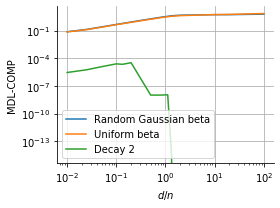

In [19]:
plt.figure(figsize=(4, 3))
# plt.axhline(df.mse_zero.values[0], lw=4, color='gray', alpha=0.4, label='trivial')
# plt.title('A', fontweight='bold', loc='left')
#         plt.plot(curve.loss_val, curve.mse_test, **kwargs) #np.square(curve.bias) + curve['var'], **kwargs)
plt.ylabel('MDL-COMP')
plt.xlabel('$d / n$') #\n(Number of features / Number of training points)')



r = pkl.load(open(f'intermediate/{dset}_mdl_comps.pkl', 'rb'))
plt.plot(1/np.array(r['n_train_over_num_features']), r['mdl_comps'], label='Random Gaussian beta')
r = pkl.load(open(f'intermediate/{dset}_mdl_comps_flat.pkl', 'rb'))
plt.plot(1/np.array(r['n_train_over_num_features']), r['mdl_comps'], label='Uniform beta')
r = pkl.load(open(f'intermediate/{dset}_mdl_comps_decay2.pkl', 'rb'))
plt.plot(1/np.array(r['n_train_over_num_features']), r['mdl_comps'], label='Decay 2')
plt.legend()


ax = plt.subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.tight_layout()
# plt.savefig(oj(save_dir, 'fig_iid_comp.pdf'))